In [97]:
%load_ext autoreload
%autoreload 2

In [98]:
from pathlib import Path
import sys, importlib.util, os
parentPath = Path.cwd().parent
sys.path.insert(0, str(parentPath))  # add project root

In [99]:
import numpy as np
from csv import DictWriter

import mne
from src.preprocessing import raw_data_filter, get_events_and_ids_eegbci
from src.datasets_eegbci import load_eegbci_raws

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
mne.set_log_level("ERROR")

In [100]:
filePath = Path(f"{parentPath}/data/raw")
derivedPath = Path(f"{parentPath}/data/derivatives")
derivedPath.mkdir(parents=True, exist_ok=True)

# choose  subjects & MI runs:
SUBJECTS = np.arange(1, 110)  # 1-109
RUNS_MI  = [3,4,5,6,7,8,9,10,11,12,13,14]  # fists L/R; 4/8/12 are IMAGERY, 3/7/11 are EXECUTION

In [101]:
raws, files = load_eegbci_raws(SUBJECTS, RUNS_MI, cache_dir=filePath)

In [ ]:
import re
import pandas as pd

raw_data_info = pd.DataFrame(columns = ['subject', 'run', 'sampling_rate', 'duration'])
for i, (raw, file) in enumerate(zip(raws, files)):
    Fs = raw.info['sfreq']
    duration = raw.times[-1]

    # Subject & run from filename
    sub = int(re.search(r"S(\d{3})", file.name).group(1))
    run = int(re.search(r"R(\d{2})", file.name).group(1))
    # print(f"subject: {sub}  run: {run}  Fs: {Fs} Hz  channel: {len(raw.ch_names)}  duration: {raw.times[-1]} s")
    raw_data_info.loc[i] = [sub, run, Fs, duration]

raw_data_info.head()

,subject,run,sampling_rate,duration
0,1.0,3.0,160.0,124.99375
1,1.0,4.0,160.0,124.99375
2,1.0,5.0,160.0,124.99375
3,1.0,6.0,160.0,124.99375
4,1.0,7.0,160.0,124.99375


### Check subject, runs with different sampling rates

In [134]:
print(raw_data_info.sampling_rate.value_counts())

sampling_rate
160.0    1272
128.0      36
Name: count, dtype: int64


In [139]:
select_sampling_rate = 160  # Hz
# Exclude subjects with different sampling rates
idx = raw_data_info[raw_data_info.sampling_rate != select_sampling_rate].index
exclude_subject_list = list(raw_data_info.loc[idx].subject.unique())
print(f" Subjects with different sampling rates: {exclude_subject_list}")


 Subjects with different sampling rates: [np.float64(88.0), np.float64(92.0), np.float64(100.0)]


# Generate epochs

In [9]:
all_epochs = []
summary_rows = []

# Epochs default parameters
tmin, tmax = -0.2, 0.8
baseline = (None, 0)

# Amplitude rejection thresholds
reject_ptp=150e-6  # 150 uV
flat=1e-6  # 1 uV
reject_dict = dict(eeg=reject_ptp)
flat_dict = dict(eeg=flat)

for raw, fname in zip(raws, files):

    # Exclude subjects with different sampling rates
    sub = int(re.search(r"S(\d{3})", fname.name).group(1))
    if sub in exclude_subject_list:
        continue

    # Pre-processing
    raw_c = raw_data_filter(raw, line_freq=60)  # 60Hz line noise
    # Events & event_id tailored to the run number
    events, event_id, inv_map, run = get_events_and_ids_eegbci(raw_c)#, two_class_only=True)
    # Epoching
    epochs = mne.Epochs(raw_c, events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=baseline, preload=True, reject=reject_dict, flat=flat_dict, verbose=False)
    # quick class counts
    y = epochs.events[:, -1]
    counts = {inv_map[int(k)]: int(v) for k, v in zip(*np.unique(y, return_counts=True))}

    # Save epochs per file
    out = derivedPath / f"epochs_S{Path(fname).name.split('S')[-1].replace('.edf','')}-epo.fif"
    epochs.save(out, overwrite=True)
    all_epochs.append(epochs)
    summary_rows.append((fname, run, counts))

    # print("Subject:", sub, "Run:", run, "event_id:", event_id)
    # print("Epochs shape:", epochs.get_data().shape)  # (n_epochs, n_channels, n_times)
    # print("Counts:", counts)
    # print("Saved:", out)
print("Total epochs files:", len(all_epochs))


Total epochs files: 1272


Length of epoch: 11


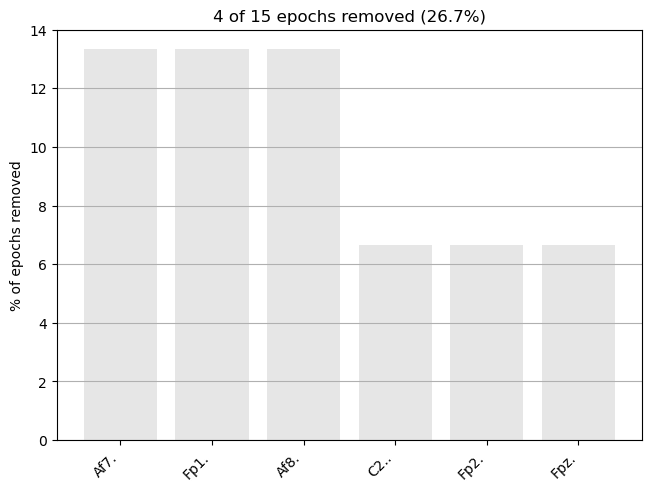

Epochs kept: 11, epoch indices kept: [ 0  1  2  3  6  7  8  9 10 11 14]


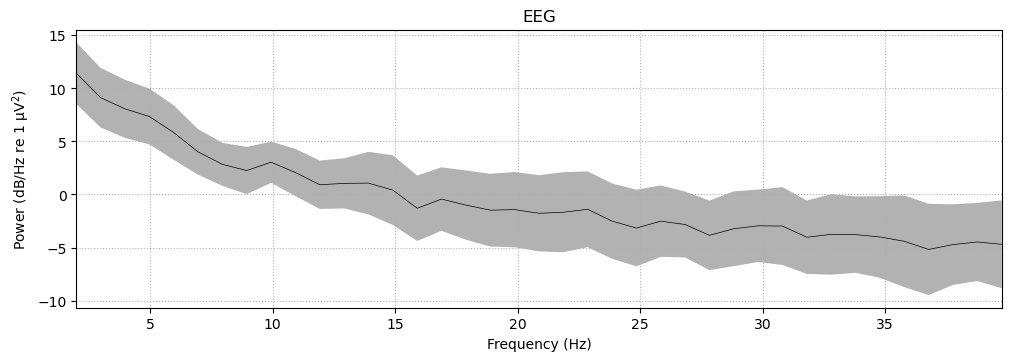

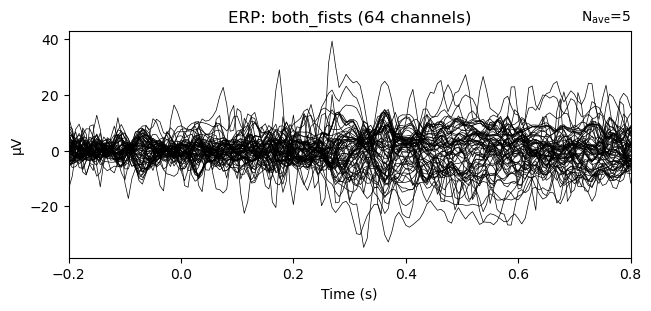

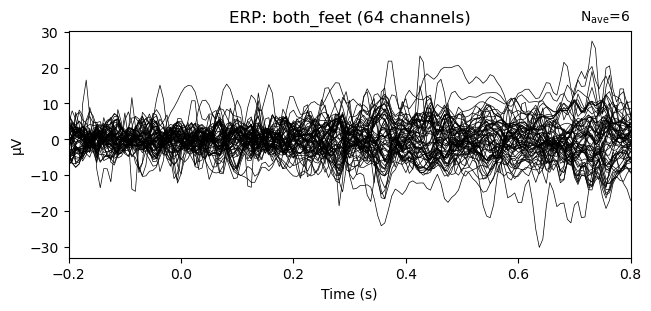

In [13]:
# Choose one epochs object to visualize
epoch_index = 122
epoch = all_epochs[epoch_index]
print(f"Length of epoch: {len(epoch)}")
# epoch.drop_log
epoch.plot_drop_log()
if len(epoch)==0:
    print("⚠️ No epochs to plot (all dropped). Showing drop log instead.")
    fig = epoch.plot_drop_log(show=False)  # always works, even if empty
else:
    print(f"Epochs kept: {len(epoch)}, epoch indices kept: {epoch.selection}")
    psd = epoch.compute_psd(fmin=1, fmax=40, method="welch")
    fig = psd.plot(average=True, show=False)
    # ERP by class name
    labels = list(epoch.event_id.keys())
    for lab in labels:
        epoch[lab].average().plot(spatial_colors=True, titles=f"ERP: {lab}")

In [107]:
EPO_FILES = sorted(derivedPath.glob("*-epo.fif"))
print(len(EPO_FILES), "epoch files found")

rows = []
for f in EPO_FILES:
    ep = mne.read_epochs(f, preload=False, verbose=False)
    y = ep.events[:, -1]
    u, c = np.unique(y, return_counts=True)
    # drop log summary
    dropped = sum(len(x)>0 for x in ep.drop_log)
    kept = len(ep)
    drop_rate = dropped / (dropped + kept) if (dropped+kept)>0 else 0.
    rows.append(dict(
        file=str(f.name),
        sfreq=float(ep.info["sfreq"]),
        n_ch=int(len(ep.ch_names)),
        classes="/".join(ep.event_id.keys()),
        counts=";".join(f"{int(ui)}:{int(ci)}" for ui,ci in zip(u,c)),
        kept=int(kept),
        dropped=int(dropped),
        drop_rate=float(drop_rate),
    ))
len(rows)


1272 epoch files found


1272

In [108]:
res = Path(f"{parentPath}/results/epoch_results.csv")
res.parent.mkdir(parents=True, exist_ok=True)

with res.open("w", newline="") as f:        # <-- 'w' = overwrite
    w = DictWriter(f, fieldnames=list(rows[0].keys()))
    w.writeheader()
    w.writerows(rows)

print(f"Wrote {len(rows)} rows to {res} (overwrote any previous file).")



Wrote 1272 rows to /Users/sumachinta/Library/CloudStorage/OneDrive-CytoTronics/github/Motor-Imagery-EEG-Classifier/results/epoch_results.csv (overwrote any previous file).


In [ ]:
# FIGS = Path(f"{parentPath}/figs"); FIGS.mkdir(exist_ok=True, parents=True)
# for f in EPO_FILES:
#     ep = mne.read_epochs(f, preload=True, verbose=False)
#     if len(ep) == 0:
#         ep.plot_drop_log(show=False).savefig(FIGS / f"droplog_{f.stem}.png", dpi=150); continue

#     fig = ep.compute_psd(fmin=1, fmax=40).plot(average=True, show=False)
#     fig.savefig(FIGS / f"psd_{f.stem}.png", dpi=150)
